# 0 - Install and import packages

In [ ]:
!pip install ahead

In [137]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from time import time
from ahead import Ridge2Regressor # may take some time to run, ONLY the 1st time it's run
from statsmodels.tsa.base.datetools import dates_from_str
from time import time

# 1 - Import data

In [138]:
# some example data
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

quarterly = dates_from_str(quarterly)

mdata = mdata[['realgovt', 'tbilrate', 'cpi', 'realgdp']]

mdata.index = pd.DatetimeIndex(quarterly)

df = np.log(mdata).diff().dropna()

display(df)

,realgovt,tbilrate,cpi,realgdp
1959-06-30,0.023664,0.088193,0.005849,0.024942
1959-09-30,0.020481,0.215321,0.006838,-0.001193
1959-12-31,-0.014781,0.125317,0.000681,0.003495
1960-03-31,-0.046197,-0.212805,0.005772,0.022190
1960-06-30,-0.003900,-0.266946,0.000338,-0.004685
...,...,...,...,...
2008-09-30,0.031005,-0.396881,-0.007904,-0.006781
2008-12-31,0.015732,-2.277267,-0.021979,-0.013805
2009-03-31,-0.010967,0.606136,0.002340,-0.016612
2009-06-30,0.026975,-0.200671,0.008419,-0.001851


In [139]:
regr = Ridge2Regressor(h = 20, date_formatting = "original",
                       type_pi="blockbootstrap", # type of simulations for predictive inference
                       B=50, # number of simulations
                       seed=1)

start = time()
regr.forecast(df)
print(f"Elapsed: {time() - start} s")

  |======================================================================| 100%
Elapsed: 0.49063634872436523 s


In [140]:
regr2 = Ridge2Regressor(h = 20, date_formatting = "original",
                       type_pi="gaussian", # Gaussian prediction intervals
                       seed=1)

start = time()
regr2.forecast(df)
print(f"Elapsed: {time() - start} s")

Elapsed: 0.038446664810180664 s


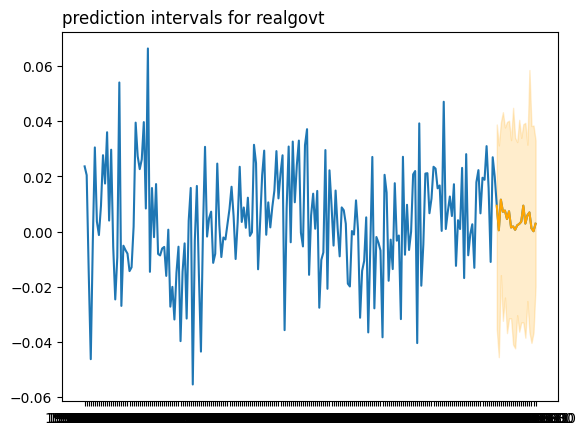

In [141]:
regr.plot("realgovt")

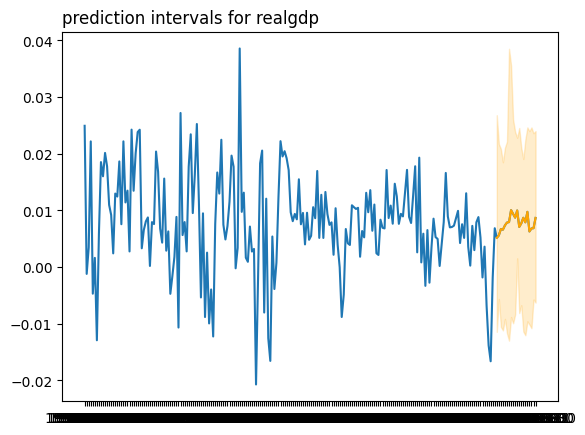

In [142]:
regr.plot("realgdp")

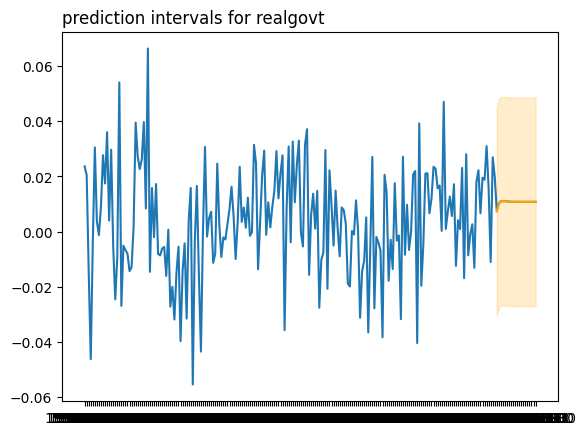

In [143]:
regr2.plot("realgovt")

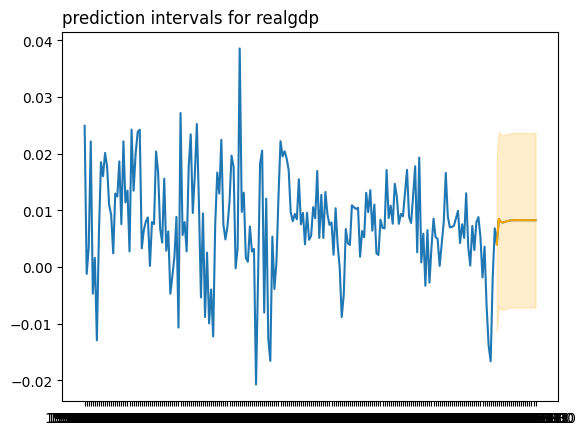

In [144]:
regr2.plot("realgdp")

# 2 - R version examples

In [145]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R

options(repos = c(
    techtonique = 'https://r-packages.techtonique.net',
    CRAN = 'https://cloud.r-project.org'))

install.packages("ahead")
install.packages("ggplot2")
install.packages("forecast")
install.packages("dfoptim")

In [147]:
%%R

library(ahead)
library(dfoptim)

In [148]:
# Convert to R DataFrame
%R -i df

/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [ ]:
%R df_ts <- as.ts(df)

In [150]:
%%R

objective_function <- function(xx)
{
    ahead::loocvridge2f(df_ts,
                        h = 20,
                        type_pi="blockbootstrap",
                        lambda_1=10^xx[1],
                        lambda_2=10^xx[2],
                        show_progress = FALSE,
                        )$loocv
}
start <- proc.time()[3]
(opt <- dfoptim::nmkb(fn=objective_function, lower=c(-10,-10), upper=c(10,10), par=c(0.1, 0.1)))
print(proc.time()[3]-start)

elapsed 
  6.657 


In [151]:
%%R

start <- proc.time()[3]
res <- ahead::ridge2f(df_ts, h = 20,
                      type_pi="blockbootstrap",
                      lambda_1=10^opt$par[1], # 'optimal' parameters
                      lambda_2=10^opt$par[2]) # 'optimal' parameters
print(proc.time()[3]-start)

  |======================================================================| 100%
elapsed 
  0.805 


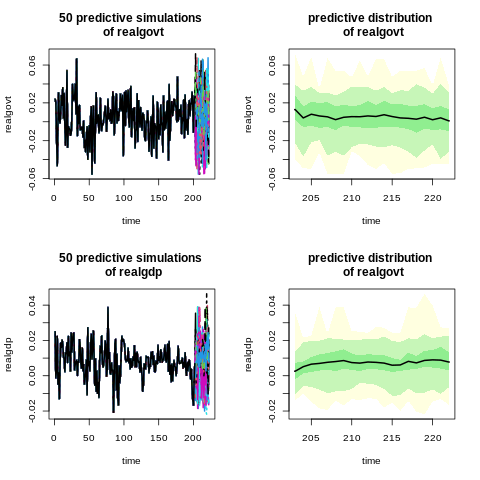

In [152]:
%%R

par(mfrow=c(2, 2))
plot(res, "realgovt", type = "sims", main="50 predictive simulations \n of realgovt")
plot(res, "realgovt", type = "dist", main="predictive distribution \n of realgovt")
plot(res, "realgdp", type = "sims", main="50 predictive simulations \n of realgdp")
plot(res, "realgdp", type = "dist", main="predictive distribution \n of realgovt")

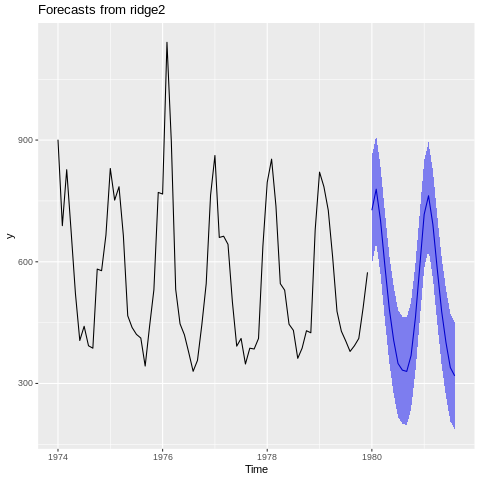

In [153]:
%%R

library(ggplot2)
library(forecast)

x <- fdeaths
xreg <- ahead::createtrendseason(x)
(z <- ahead::ridge2f(x, xreg = xreg, h=20))
autoplot(z)